# Reflextion

Reflexion by Shinn, et. al., is an architecture designed to learn through verbal feedback and self-reflection. The agent explicitly critiques its responses for tasks to generate a higher quality final response, at the expense of longer execution time.
- https://arxiv.org/abs/2303.11366

The paper outlines 3 main components:
- 1. Actor (agent) with self-reflection
- 2. External evaluator (task-specific, e.g. code compilation steps)
- 3. Episodic memory that stores the reflections from (1).

In their code, the last two components are very task-specific, so in this notebook, you will build the actor in LangGraph.

To skip to the graph definition, see the Construct Graph section below.

![](./images/Reflextion.png)

In [1]:
%pip install -U --quiet  langgraph langchain_openai quiet tavily-python

ERROR: Could not find a version that satisfies the requirement quiet (from versions: none)
ERROR: No matching distribution found for quiet

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()

## 1. Actor (with reflection)

The main component of Reflexion is the "actor", which is an agent that reflects on its response and re-executes to improve based on self-critique. It's main sub-components include:

Tools/tool execution
Initial responder: generate an initial response (and self-reflection)
Revisor: re-respond (and reflec) based on previous reflections
We'll first define the tool execution context.


### Construct tools



In [3]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)


### Initial responder


In [9]:
from langchain_core.messages import HumanMessage, ToolMessage
from langchain_core.output_parsers.openai_tools import PydanticToolsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.pydantic_v1 import BaseModel, Field, ValidationError


class Reflection(BaseModel):
    missing: str = Field(description="Critique of what is missing.")
    superfluous: str = Field(description="Critique of what is superfluous")

class AnswerQuestion(BaseModel):
    """Answer the question. Provide an answer, reflection, and then follow up with search queries to improve the answer."""

    answer: str = Field(description="~250 word detailed answer to the question.")
    reflection: Reflection = Field(description="Your reflection on the initial answer.")
    search_queries: list[str] = Field(
        description="1-3 search queries for researching improvements to address the critique of your current answer."
    )

class ResponderWithRetries:
    def __init__(self, runnable, validator):
        self.runnable = runnable
        self.validator = validator

    def respond(self, state: list):
        response = []
        for attempt in range(3):
            response = self.runnable.invoke(
                {"messages": state}, {"tags": [f"attempt:{attempt}"]}
            )
            print("==========response==========")
            try:
                self.validator.invoke(response)
                print(response)
                return response
            except ValidationError as e:
                state = state + [
                    response,
                    ToolMessage(
                        content=f"{repr(e)}\n\nPay close attention to the function schema.\n\n"
                        + self.validator.schema_json()
                        + " Respond by fixing all validation errors.",
                        tool_call_id=response.tool_calls[0]["id"],
                    ),
                ]
        return response


In [10]:
import datetime

actor_prompt_template = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are expert researcher.
Current time: {time}

1. {first_instruction}
2. Reflect and critique your answer. Be severe to maximize improvement.
3. Recommend search queries to research information and improve your answer.""",
        ),
        MessagesPlaceholder(variable_name="messages"),
        (
            "user",
            "\n\n<system>Reflect on the user's original question and the"
            " actions taken thus far. Respond using the {function_name} function.</reminder>",
        ),
    ]
).partial(
    time=lambda: datetime.datetime.now().isoformat(),
)

initial_answer_chain = actor_prompt_template.partial(
    first_instruction="Provide a detailed ~250 word answer.",
    function_name=AnswerQuestion.__name__,
) | llm.bind_tools(tools=[AnswerQuestion])

validator = PydanticToolsParser(tools=[AnswerQuestion])

first_responder = ResponderWithRetries(
    runnable=initial_answer_chain, validator=validator
)


In [11]:
example_question = "Why is reflection useful in AI?"

initial = first_responder.respond([HumanMessage(content=example_question)])

==========response==========
content='' additional_kwargs={'tool_calls': [{'id': 'call_7Sa7RKY5FAjjtSNUfyPechPc', 'function': {'arguments': '{"answer":"Reflection is useful in AI for several reasons. It allows AI systems to learn from past experiences and improve their performance over time. By reflecting on past decisions and outcomes, AI can identify patterns, errors, and successes to adjust its future actions accordingly. Reflection also enables AI to explain its reasoning and decision-making processes, increasing transparency and trust in AI systems. Additionally, through reflection, AI can adapt to changes in its environment or tasks, making it more versatile and effective in various scenarios. Overall, reflection in AI is crucial for continuous learning, self-improvement, adaptability, and transparency, leading to more reliable and efficient AI systems.","reflection":{"missing":"An example illustrating how reflection is implemented in AI systems could further enhance the answer."

In [30]:
initial.additional_kwargs['tool_calls'][0]['function']['arguments']

'{"answer":"Reflection is useful in AI for several reasons. It allows AI systems to learn from past experiences and improve their performance over time. By reflecting on past decisions and outcomes, AI can identify patterns, errors, and successes to adjust its future actions accordingly. Reflection also enables AI to explain its reasoning and decision-making processes, increasing transparency and trust in AI systems. Additionally, through reflection, AI can adapt to changes in its environment or tasks, making it more versatile and effective in various scenarios. Overall, reflection in AI is crucial for continuous learning, self-improvement, adaptability, and transparency, leading to more reliable and efficient AI systems.","reflection":{"missing":"An example illustrating how reflection is implemented in AI systems could further enhance the answer.","superfluous":"The explanation could be more focused on specific techniques or methodologies used for reflection in AI systems."},"search_q

In [32]:
import json 

data = json.loads(initial.additional_kwargs['tool_calls'][0]['function']['arguments'])

answer = data['answer']

reflection = data['reflection']

search_queries = data['search_queries']

{'answer': 'Reflection is useful in AI for several reasons. It allows AI systems to learn from past experiences and improve their performance over time. By reflecting on past decisions and outcomes, AI can identify patterns, errors, and successes to adjust its future actions accordingly. Reflection also enables AI to explain its reasoning and decision-making processes, increasing transparency and trust in AI systems. Additionally, through reflection, AI can adapt to changes in its environment or tasks, making it more versatile and effective in various scenarios. Overall, reflection in AI is crucial for continuous learning, self-improvement, adaptability, and transparency, leading to more reliable and efficient AI systems.',
 'reflection': {'missing': 'An example illustrating how reflection is implemented in AI systems could further enhance the answer.',
  'superfluous': 'The explanation could be more focused on specific techniques or methodologies used for reflection in AI systems.'},


## Revision
The second part of the actor is a revision step.



In [34]:
revise_instructions = """Revise your previous answer using the new information.
    - You should use the previous critique to add important information to your answer.
        - You MUST include numerical citations in your revised answer to ensure it can be verified.
        - Add a "References" section to the bottom of your answer (which does not count towards the word limit). In form of:
            - [1] https://example.com
            - [2] https://example.com
    - You should use the previous critique to remove superfluous information from your answer and make SURE it is not more than 250 words.
"""

# Extend the initial answer schema to include references.
# Forcing citation in the model encourages grounded responses
class ReviseAnswer(AnswerQuestion):
    """Revise your original answer to your question. Provide an answer, reflection,

    cite your reflection with references, and finally
    add search queries to improve the answer."""

    references: list[str] = Field(
        description="Citations motivating your updated answer."
    )


revision_chain = actor_prompt_template.partial(
    first_instruction=revise_instructions,
    function_name=ReviseAnswer.__name__,
) | llm.bind_tools(tools=[ReviseAnswer])
revision_validator = PydanticToolsParser(tools=[ReviseAnswer])

revisor = ResponderWithRetries(runnable=revision_chain, validator=revision_validator)


In [35]:
import json

revised = revisor.respond(
    [
        HumanMessage(content=example_question),
        initial,
        ToolMessage(
            tool_call_id=initial.tool_calls[0]["id"],
            content=json.dumps(
                tavily_tool.invoke(
                    {"query": initial.tool_calls[0]["args"]["search_queries"][0]}
                )
            ),
        ),
    ]
)
revised


==========response==========
content='' additional_kwargs={'tool_calls': [{'id': 'call_qdgQC4gaT2CAElE9ISqawdj0', 'function': {'arguments': '{"answer":"Reflection is essential in AI to facilitate continuous learning, self-improvement, adaptability, and transparency. AI systems utilize reflection to analyze past experiences, identify patterns, errors, and successes, and adjust their future actions accordingly. This process enhances AI\'s performance and allows it to evolve intelligently in dynamic environments, leading to more reliable and efficient systems. For example, LangGraph employs reflection agents to enhance code generation by allowing nodes to retry failed checks, showcasing the practical application of reflection in improving AI processes.","reflection":{"missing":"An example illustrating how reflection is implemented in AI systems could further enhance the answer.","superfluous":"The explanation could be more focused on specific techniques or methodologies used for reflectio

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qdgQC4gaT2CAElE9ISqawdj0', 'function': {'arguments': '{"answer":"Reflection is essential in AI to facilitate continuous learning, self-improvement, adaptability, and transparency. AI systems utilize reflection to analyze past experiences, identify patterns, errors, and successes, and adjust their future actions accordingly. This process enhances AI\'s performance and allows it to evolve intelligently in dynamic environments, leading to more reliable and efficient systems. For example, LangGraph employs reflection agents to enhance code generation by allowing nodes to retry failed checks, showcasing the practical application of reflection in improving AI processes.","reflection":{"missing":"An example illustrating how reflection is implemented in AI systems could further enhance the answer.","superfluous":"The explanation could be more focused on specific techniques or methodologies used for reflection in AI systems."}

## Create Tool Node
Next, create a node to execute the tool calls. While we give the LLMs different schema names (and use those for validation), we want them both to route to the same tool.



In [38]:
from langchain_core.tools import StructuredTool

from langgraph.prebuilt import ToolNode


def run_queries(search_queries: list[str], **kwargs):
    """Run the generated queries."""
    return tavily_tool.batch([{"query": query} for query in search_queries])


tool_node = ToolNode(
    [
        StructuredTool.from_function(run_queries, name=AnswerQuestion.__name__),
        StructuredTool.from_function(run_queries, name=ReviseAnswer.__name__),
    ]
)



## Construct Graph
Now we can wire all our components together.



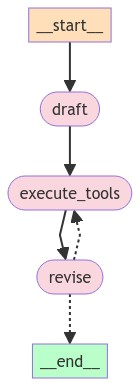

In [40]:

from typing import Literal

from langgraph.graph import END, MessageGraph

MAX_ITERATIONS = 5
builder = MessageGraph()
builder.add_node("draft", first_responder.respond)

builder.add_node("execute_tools", tool_node)
builder.add_node("revise", revisor.respond)

# draft -> execute_tools
builder.add_edge("draft", "execute_tools")
# execute_tools -> revise
builder.add_edge("execute_tools", "revise")


# Define looping logic:


def _get_num_iterations(state: list):
    i = 0
    for m in state[::-1]:
        if m.type not in {"tool", "ai"}:
            break
        i += 1
    return i


def event_loop(state: list) -> Literal["execute_tools", "__end__"]:
    # in our case, we'll just stop after N plans
    num_iterations = _get_num_iterations(state)
    if num_iterations > MAX_ITERATIONS:
        return END
    return "execute_tools"


# revise -> execute_tools OR end
builder.add_conditional_edges("revise", event_loop)
builder.set_entry_point("draft")
graph = builder.compile()

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass


In [41]:
events = graph.stream(
    [HumanMessage(content="How should we handle the climate crisis?")],
    stream_mode="values",
)
for i, step in enumerate(events):
    print(f"Step {i}")
    step[-1].pretty_print()


Step 0
================================ Human Message =================================

How should we handle the climate crisis?
==========response==========
content='' additional_kwargs={'tool_calls': [{'id': 'call_wJ43wwjI1RvfOYyHbbsV5iBV', 'function': {'arguments': '{"answer":"Addressing the climate crisis requires a multi-faceted approach involving governments, businesses, and individuals. Policymakers need to implement regulations that reduce greenhouse gas emissions, promote renewable energy sources, and protect natural habitats. Businesses can play a crucial role by adopting sustainable practices, investing in clean technologies, and reducing their carbon footprint. Individuals also have a part to play by making environmentally conscious choices in their daily lives, such as using public transportation, reducing waste, and supporting eco-friendly products. Education and awareness campaigns are essential to inform the public about the urgency of the climate crisis and the action

## Conclusion
Congrats on building a Reflexion actor! I'll leave you with a few observations to save you some time when choosing which parts of this agent to adapt to your workflow:

This agent trades off execution time for quality. It explicitly forces the agent to critique and revise the output over several steps, which usually (not always) increases the response quality but takes much longer to return a final answer
The 'reflections' can be paired with additional external feedback (such as validators), to further guide the actor.
In the paper, 1 environment (AlfWorld) uses external memory. It does this by storing summaries of the reflections to an external store and using them in subsequent trials/invocations.
